In [87]:
import pandas as pd
import math
import numpy as np

In [88]:
#calculate entropy
def entropy(data, outcome_label, weight_label):
     
    """
    y is the outcome data series
    weight is the weight series
    """
    total_weights = np.sum(data[weight_label])
    class_weights = data.groupby(by = outcome_label).sum()[weight_label]

    probabilities = class_weights / total_weights
    entropy = -np.sum(probabilities * np.log2(probabilities))

    return entropy

#calculate information gain for each feature in each level
def information_gain_fun(data, features, outcome_label, weight_label):

    """
    X is the feature data
    y is the outcome data series
    weight is the weight series
    """
    total_entropy = entropy(data, outcome_label, weight_label)

    len_features = len(features)

    output_table = pd.DataFrame(columns = ['factor','decision_value'])

    for i1 in range(len_features):
        feature = features[i1]
        length_feature = len(data[feature])
        feature_categorpy = data[feature].unique()
        
        expected_entropy = 0

        for category in sorted(feature_categorpy):
            
            #subcategory data
            sub_data = data[data[feature] == category]

            #subcategory entropy
            sub_entropy = entropy(sub_data, outcome_label, weight_label)

            proportion = np.sum(sub_data[weight_label])/np.sum(data[weight_label]) #proportion of one category of a feature
            sub_entropy_category = proportion*sub_entropy

            #total weight of this feature
            expected_entropy += sub_entropy_category

        #weighted of this feature
        information_gain = total_entropy - expected_entropy

        row = {'factor': feature,"decision_value":information_gain}
        output_table = pd.concat([output_table, pd.DataFrame([row])], ignore_index = True)

    # Find the index of the maximum value in the 'decision_value' column
    max_index = output_table['decision_value'].idxmax()

    # Get the factor with max value
    max_factor = output_table.loc[max_index, 'factor']

    return max_factor


def ID3 (data, features, outcome_label, weight_label, current_depth, max_depth):
    trees = {}
    
    #If all target labels are the same, return label
    if data[outcome_label].nunique() == 1:
        output_y = data[outcome_label].unique()[0]
        return output_y

    # If no more features2 are available, return the most common label
    elif len(features) == 0 or (current_depth >= max_depth) :
        return data[outcome_label].mode()[0]
        
    else:
        best_feature1 = information_gain_fun(data, features, outcome_label, weight_label)
        #Innitial tree with best features2:
        trees[best_feature1] = {}

        for i in data[best_feature1].unique():

            split_tree_data = data[data[best_feature1] == i]
            
            if split_tree_data.empty:
                trees[best_feature1][i] = data[outcome_label].mode()[0]

            else:
                new_features = [f for f in features if f != best_feature1]
                update_data = split_tree_data.loc[:, split_tree_data.columns != best_feature1]
                subtree = ID3(update_data, new_features, outcome_label, weight_label, current_depth+1, max_depth) #call ID3 again
                trees[best_feature1][i] = subtree
                
        return trees

In [89]:
def predict_one (trees, predictor_data):

    if not isinstance(trees, dict):
        return trees
    
    parent_node = next(iter(trees)) #parent node
    subtree = trees[parent_node] #subtree of parent_node
    node_value = predictor_data[parent_node]  #the value of the parent in the first observation

    if node_value in subtree:
        return predict_one(subtree[node_value], predictor_data)
    
    else: 
        return None
    
def predict(trees, verify_data, features): #test
    predict_values = []

    for i, row in verify_data.iterrows():
        predictors = row[features].to_dict()
        predict_value = predict_one(trees, predictors) #predicted y
        predict_values.append(predict_value)
        
    return predict_values

def predict_ensemble(classifiers, alphas, data, features):
    """
    Predict using the ensemble of weak learners and their weights (alphas).
    """
    weighted_sum = np.zeros(len(data))

    # Iterate over each classifier and its corresponding alpha value
    for clf, alpha in zip(classifiers, alphas):
        predictions = predict(clf, data, features)  # Get the predictions from the current weak classifier
        
        # Add the weighted predictions to the sum
        weighted_sum += alpha * np.array(predictions)

    return np.sign(weighted_sum)# Return the sign of the weighted sum as the final prediction

def calculate_error(predictions, true_labels):
    incorrect = predictions != true_labels
    error = np.sum(incorrect) / len(true_labels)
    return error

In [90]:
def Adaboost2 (train_data_att, test_data_att, iterations, features, outcome_label, weight_label, current_depth, max_depth):
    individual_training_errors = []
    individual_testing_errors = []
    training_errors = []
    testing_errors = []
    classifiers = []
    alphas = []
    
    for i in range(iterations):
        max_depth = 2 #range from 1-16
        current_depth = 0
        
        decision_stump = ID3(train_data_att, features, outcome_label, weight_label, current_depth, max_depth) #with only two levels
        
        #Predict on the training
        predict_train_value = predict (decision_stump, train_data_att, features)
        train_error = calculate_error(predict_train_value, train_data_att[outcome_label])
        individual_training_errors.append(1-train_error)

        #Predict on the testing data
        predict_test_value = predict (decision_stump, test_data_att, features)
        test_error = calculate_error(predict_test_value, test_data_att[outcome_label])
        individual_testing_errors.append(1-test_error)

        # Update weights
        incorrect_train = predict_train_value != train_data_att[outcome_label]
        epsilon_t = np.sum(train_data_att[incorrect_train][weight_label])
        epsilon_t = np.clip(epsilon_t, 1e-10, 1 - 1e-10)
        print(epsilon_t)

        alpha = 0.5 * np.log((1 - epsilon_t) / epsilon_t) #update alpha
        #print(alpha)
        
        alphas.append(alpha)
        classifiers.append(decision_stump)

        #Claculate error with ensemble tree
        all_predictions_train = predict_ensemble(classifiers, alphas, train_data_att, features)
        all_train_error = calculate_error(all_predictions_train, train_data_att[outcome_label])
        training_errors.append(1-all_train_error)

        all_predictions_test= predict_ensemble(classifiers, alphas, test_data_att, features)
        all_test_error = calculate_error (all_predictions_test, test_data_att[outcome_label])
        testing_errors.append(1-all_test_error)

        exp_factors = np.exp(-alpha *train_data_att[outcome_label] *predict_train_value)
        Zt = np.sum(train_data_att[weight_label]*exp_factors)
        Dtnext = (train_data_att[weight_label]*exp_factors)/Zt
        train_data_att[weight_label] = Dtnext
        #print(Dtnext)

    return classifiers, alphas, individual_training_errors, individual_testing_errors, training_errors, testing_errors, 

In [91]:
#regard unknown as a particular attribute
def data_preprocessing_attribute(data, features, continuous):
    for var in features:
        if var in continuous:
            media = data[var].median() #replace with median
            data[var] = data[var].apply(lambda x:"no" if x < media else 'yes')

    return data

In [92]:
#load data
train_data = pd.read_csv("D:\\EIC-Code\\00-Python\\Machine-Learning-HW\\DecisionTree\\bank\\train.csv",header = None, 
names = ['age','job','marital','education','default','balance','housing','loan','contact','day','month','duration','campaign','pdays','previous','poutcome','y'])

test_data = pd.read_csv("D:\\EIC-Code\\00-Python\\Machine-Learning-HW\\DecisionTree\\bank\\test.csv", header = None, 
names = ['age','job','marital','education','default','balance','housing','loan','contact','day','month','duration','campaign','pdays','previous','poutcome','y'])

features = ['age', 'job', 'marital','education', 'default', 'balance', 'housing','loan', 'contact', 'day','month', 
            'duration','campaign','pdays','previous', 'poutcome']

continuous = ['age', 'balance', 'day','duration','campaign','pdays','previous']

#load data
train_data_att = data_preprocessing_attribute(train_data.copy(), features, continuous)
test_data_att = data_preprocessing_attribute(test_data.copy(), features, continuous)

train_data_att['y'] = train_data_att['y'].map(lambda label: 1 if label == 'yes' else -1) 
test_data_att['y'] = test_data_att['y'].map(lambda label: 1 if label == 'yes' else -1) 

In [93]:
iterations = 500
train_data_att['weight_columns'] = 1/len(train_data_att)
weight_column = train_data_att['weight_columns'] 
outcome_label = 'y'
weight_label = 'weight_columns'
current_depth = 0
max_depth = 2

classifiers, alphas, individual_training_errors, individual_testing_errors, training_errors, testing_errors = Adaboost2 (train_data_att, 
                                                                                                                         test_data_att, 
                                                                                                                         iterations, 
                                                                                                                         features, 
                                                                                                                         outcome_label, 
                                                                                                                         weight_label, 
                                                                                                                         current_depth, 
                                                                                                                         max_depth)

0.10600000000000002
0.4400468532354058
0.5427680766402447
0.5000000000000002
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5


KeyboardInterrupt: 

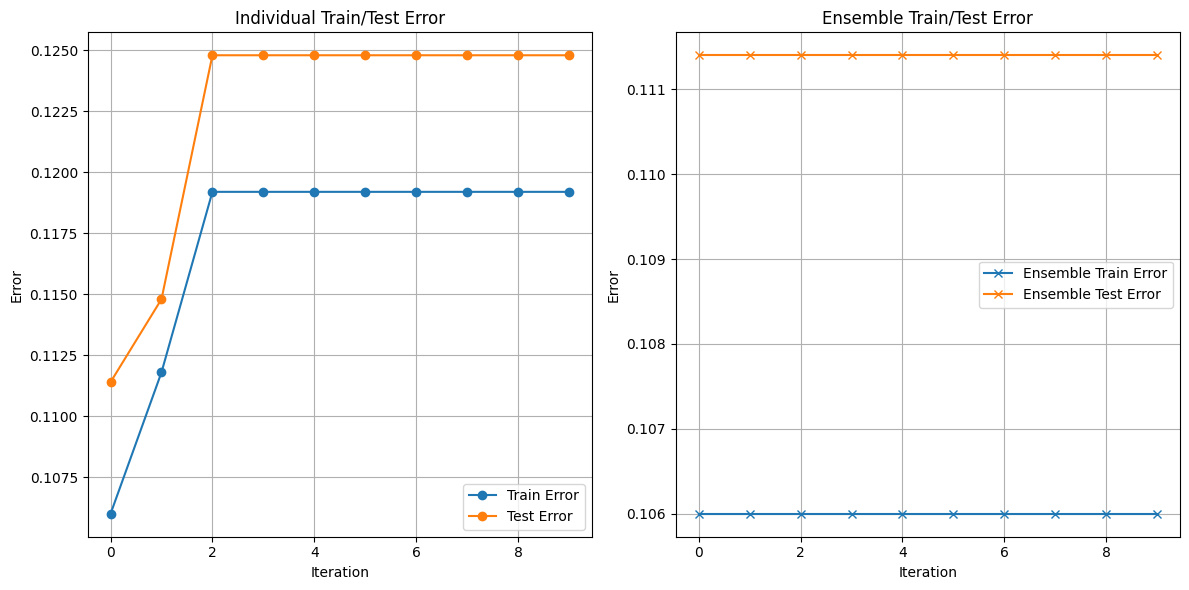

In [85]:
#plot figure
import matplotlib.pyplot as plt

# Plot the errors separately: one graph for individual train/test errors, another for ensemble errors
plt.figure(figsize=(12, 6))

# Plot train and test errors in the first graph
plt.subplot(1, 2, 1)
plt.plot([i for i in range(iterations)], individual_training_errors, label='Train Error', marker='o')
plt.plot([i for i in range(iterations)], individual_testing_errors, label='Test Error', marker='o')
plt.title('Individual Train/Test Error')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.legend()
plt.grid(True)

# Plot ensemble train and test errors in the second graph
plt.subplot(1, 2, 2)
plt.plot([i for i in range(iterations)], training_errors, label='Ensemble Train Error', marker='x')
plt.plot([i for i in range(iterations)], testing_errors, label='Ensemble Test Error', marker='x')
plt.title('Ensemble Train/Test Error')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
def Adaboost (train_data_att, test_data_att, iterations, features, outcome_label, weight_label, current_depth, max_depth):
    classifiers = []
    alphas = []
    individual_training_errors = []
    individual_testing_errors = []
    training_errors = []
    testing_errors = []

    for i in range(iterations):

        max_depth = 2 #range from 1-16
        current_depth = 0
        
        decision_stump = ID3 (train_data_att, features, outcome_label, weight_label, current_depth, max_depth) #with only two levels
    
        #Predict on the training
        predict_train_value = predict (decision_stump, train_data_att, features)
        incorrect_train = predict_train_value != train_data_att[outcome_label]
        epsilon_train = np.sum(train_data_att[weight_label][incorrect_train])
        individual_training_errors.append(epsilon_train)

        #Predict on the testing data
        predict_test_value = predict (decision_stump, test_data_att, features)
        incorrect_test = predict_test_value != test_data_att[outcome_label]
        epsilon_test = np.sum(train_data_att[weight_label][incorrect_test])
        individual_testing_errors.append(epsilon_test)

        # Update weights
        alpha = 0.5 * np.log((1 - epsilon_train) / epsilon_train) #update alpha
        #print(alpha)
        
        alphas.append(alpha)
        classifiers.append(decision_stump)

        exp_factors = np.exp(-alpha * train_data_att[outcome_label] *predict_train_value)
        Zt = np.sum(train_data_att[weight_label]*exp_factors)
        Dtnext = (train_data_att[weight_label]*exp_factors)/Zt
        train_data_att[weight_label] = Dtnext
        #print(Dtnext)

        #calculate the training error 
        gamma = 0.5 - epsilon_train
        training_error_bound = np.exp(-2 * (gamma ** 2) * i)
        training_errors.append(training_error_bound)

        #calculate the testing error
        gamma = 0.5 - epsilon_test
        testing_error_bound = np.exp(-2 * (gamma ** 2) * i)
        testing_errors.append(testing_error_bound)
        
    return classifiers, alphas, individual_training_errors, individual_testing_errors, training_errors, testing_errors

classifiers, alphas, individual_training_errors, individual_testing_errors, training_errors, testing_errors = Adaboost (train_data_att, 
                                                                                                                        test_data_att, 
                                                                                                                        iterations, 
                                                                                                                        features, 
                                                                                                                        outcome_label, 
                                                                                                                        weight_label, 
                                                                                                                        current_depth, 
                                                                                                                        max_depth)